### Training a Model for Plate `Detection`

The problem with the previous trianed models (yolov8n), is that they do not retrun any keypoints so that we could apply a perspective transform.  
Therefore, we need to modify the yaml file and specify keypoints, and then use a yolov8n-pose model.

For training a model that returns keypoints, we use the original 1000-YoloDataset dataset, as it includes labels with the standard format for yolov8n-pose.  
By standard format I mean < class-index > < centerx > < centery > < width > < height > < px1 > < py1 > < px2 > < py2 > ... < pxn > < pyn >

#### Notice:
The dataset must be in the directory :  
/content/datasets/1000-YoloDataset  
  
The yaml file must be in the directory :  
/content/datasets/1000-YoloDataset/data.yaml  
  
The content of the yaml file must be :  
path: 1000-YoloDataset  
train: ../train/images  
val: ../val/images  
nc: 1  
nkpt: 4  
names: ['license_plate']  
kpt_shape: [4, 2]  


In [ ]:
!pip install ultralytics --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 922.1/922.1 kB 53.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 100.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.9 MB/s eta 0:00:00


In [ ]:
!gdown 14BdrG2oEm7K9O-L-t-lfsSPjKSHKTYP-

Downloading...
From (original): https://drive.google.com/uc?id=14BdrG2oEm7K9O-L-t-lfsSPjKSHKTYP-
From (redirected): https://drive.google.com/uc?id=14BdrG2oEm7K9O-L-t-lfsSPjKSHKTYP-&confirm=t&uuid=54c0b172-2a6b-45b8-a622-b01e37a965ac
To: /content/1000-YoloDataset.zip
100% 596M/596M [00:11<00:00, 50.0MB/s]


In [ ]:
!unzip -qq 1000-YoloDataset.zip

In [ ]:
!mkdir datasets
!mv 1000-YoloDataset datasets

In [ ]:
!gdown 1rZBnSW-sT-DiK-PTzgH3I9hPfchRpi4v
!mv data.yaml datasets/1000-YoloDataset

In [ ]:
!mkdir /content/datasets/1000-YoloDataset/train
!mv /content/datasets/1000-YoloDataset/images /content/datasets/1000-YoloDataset/train
!mv /content/datasets/1000-YoloDataset/labels /content/datasets/1000-YoloDataset/train

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [ ]:
# making a val dataset

import os
import shutil
import random

train_images_dir = "datasets/1000-YoloDataset/train/images"
train_labels_dir = "datasets/1000-YoloDataset/train/labels"
val_images_dir = "datasets/1000-YoloDataset/val/images"
val_labels_dir = "datasets/1000-YoloDataset/val/labels"

os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(val_labels_dir, exist_ok=True)

image_files = sorted(os.listdir(train_images_dir))
label_files = sorted(os.listdir(train_labels_dir))

assert len(image_files) == len(label_files), "Mismatch between images and labels count."

sample_indices = random.sample(range(len(image_files)), 50)

# Move the selected files to the validation folders
for idx in sample_indices:
    image_file = image_files[idx]
    label_file = label_files[idx]

    # Move image
    shutil.move(
        os.path.join(train_images_dir, image_file),
        os.path.join(val_images_dir, image_file)
    )

    # Move corresponding label
    shutil.move(
        os.path.join(train_labels_dir, label_file),
        os.path.join(val_labels_dir, label_file)
    )

print("Moved 50 images and their corresponding labels to the validation set.")


Moved 50 images and their corresponding labels to the validation set.


#### Training a Yolov8n-pose model

In [ ]:
from ultralytics import YOLO

# Start with a standard YOLO model
model = YOLO('yolov8n-pose.pt')

# Modify the model architecture for your custom keypoint task
model.model.nc = 1  # number of classes
model.model.kpt_shape = [4, 2]  # 5 keypoints, x and y

# Train the model
results = model.train(data='datasets/1000-YoloDataset/data.yaml', epochs=100, imgsz=640)

Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=pose, mode=train, model=yolov8n-pose.pt, data=datasets/1000-YoloDataset/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train5, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=Tr

train: Scanning /content/datasets/1000-YoloDataset/train/labels.cache... 949 images, 0 backgrounds, 0 corrupt: 100%|██████████| 949/949 [00:00<?, ?it/s]

train: WARNING ⚠️ /content/datasets/1000-YoloDataset/train/images/20240425_084847.JPG: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/1000-YoloDataset/train/images/20240425_085233.JPG: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/1000-YoloDataset/train/images/20240425_085536.JPG: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/1000-YoloDataset/train/images/20240425_090910.JPG: 1 duplicate labels removed
train: WARNING ⚠️ /content/datasets/1000-YoloDataset/train/images/20240425_090951.JPG: 1 duplicate labels removed
WARNING ⚠️ No 'flip_idx' array defined in data.yaml, setting augmentation 'fliplr=0.0'
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/1000-YoloDataset/val/labels.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]


Plotting labels to runs/pose/train5/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.0005), 72 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/pose/train5
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.47G      2.365      5.804          0       4.24      1.664          9        640: 100%|██████████| 60/60 [00:25<00:00,  2.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         50         54      0.913      0.778      0.844      0.522       0.52      0.261      0.233     0.0356



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.23G      1.269       2.16          0     0.9588      1.069         13        640: 100%|██████████| 60/60 [00:23<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         50         54      0.939       0.85      0.881       0.61      0.907      0.908      0.943      0.771



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.22G      1.262      1.179          0     0.8659      1.049         17        640: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         50         54       0.94      0.833      0.881      0.652      0.943      0.923      0.934      0.732



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.22G      1.164     0.9217          0     0.7775      1.011          4        640: 100%|██████████| 60/60 [00:23<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         54      0.952      0.852      0.889      0.625      0.971       0.87      0.945      0.638



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.22G      1.128     0.8375          0     0.7504      1.004          4        640: 100%|██████████| 60/60 [00:23<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         54      0.885      0.907        0.9      0.637      0.958      0.981      0.982      0.897



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.24G      1.023     0.7905          0      0.713     0.9833          3        640: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         50         54      0.891      0.904       0.89      0.678      0.963      0.977      0.983      0.936



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.22G      1.036     0.6801          0     0.7136     0.9866          9        640: 100%|██████████| 60/60 [00:23<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         50         54      0.936      0.889      0.892      0.706      0.964      0.979      0.984      0.951



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.22G     0.9631     0.6326          0     0.6621     0.9565          7        640: 100%|██████████| 60/60 [00:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         54      0.922      0.879      0.897      0.727      0.943      0.981      0.978      0.955



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.22G     0.9187     0.5482          0     0.6294     0.9372         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         50         54      0.932       0.87      0.895       0.73      0.961      0.963      0.973      0.956



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.22G      0.878     0.5265          0     0.5921     0.9087          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.68it/s]

                   all         50         54      0.946      0.833       0.88      0.742       0.93      0.981      0.983       0.97



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.22G      0.894     0.5344          0     0.5974     0.9222         13        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.37it/s]

                   all         50         54      0.905      0.881       0.91      0.775      0.946       0.98      0.983      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.22G      0.859      0.454          0     0.5771     0.9182          9        640: 100%|██████████| 60/60 [00:21<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.59it/s]

                   all         50         54        0.9      0.907       0.91      0.739      0.962      0.981      0.984      0.974



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.23G     0.8145     0.4388          0     0.5479     0.8963          6        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         50         54      0.938      0.907      0.912      0.756      0.977      0.981      0.988      0.958



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.22G     0.8035     0.4437          0     0.5676     0.9063         11        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         50         54      0.918      0.889      0.895      0.738      0.981      0.969      0.986      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.22G     0.8423     0.4238          0      0.564     0.9094         12        640: 100%|██████████| 60/60 [00:22<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.08it/s]

                   all         50         54      0.941      0.883      0.902       0.73      0.946       0.97      0.983      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.22G     0.8115     0.4163          0     0.5534     0.8917         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.30it/s]

                   all         50         54      0.959      0.867      0.916      0.782      0.941      0.981      0.986      0.965



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.22G     0.7804     0.3885          0     0.5284     0.8826          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.39it/s]

                   all         50         54       0.89      0.902      0.907      0.779      0.963      0.976      0.985      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.22G     0.7877      0.439          0     0.5464     0.8858          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.51it/s]

                   all         50         54      0.896      0.889      0.881       0.74      0.972      0.963      0.981      0.971



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.22G     0.8085     0.4377          0     0.5375     0.8938          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.13it/s]

                   all         50         54      0.883      0.907        0.9      0.773      0.964      0.981      0.984      0.978



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.24G     0.8105      0.432          0     0.5352        0.9         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.58it/s]

                   all         50         54      0.925      0.907      0.908      0.742          1       0.98      0.988      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.22G     0.7597     0.4255          0     0.5335     0.8819         11        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         50         54      0.907      0.907      0.909      0.785      0.981      0.981      0.989      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.22G     0.7461     0.3133          0     0.5132     0.8887          5        640: 100%|██████████| 60/60 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         50         54      0.955       0.87      0.906      0.768      0.946      0.976      0.985       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.22G     0.7362     0.2967          0     0.4858     0.8846         10        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.15it/s]

                   all         50         54      0.891      0.907      0.892      0.745      0.963      0.981      0.986      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.22G     0.7328     0.4252          0     0.5182     0.8834          7        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         50         54      0.941      0.879      0.913      0.795      0.978      0.981      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.22G     0.6944     0.3113          0     0.4752     0.8649         10        640: 100%|██████████| 60/60 [00:22<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.46it/s]

                   all         50         54      0.948      0.889       0.91      0.794      0.981      0.977      0.987      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.22G     0.7448     0.3428          0        0.5      0.874          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         50         54      0.935      0.889       0.91      0.728      0.963      0.977      0.987      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.22G     0.7348     0.3213          0     0.4721     0.8751          7        640: 100%|██████████| 60/60 [00:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         50         54      0.886      0.907      0.895      0.756       0.93      0.979      0.981      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.22G     0.6877     0.3083          0     0.4654     0.8702          7        640: 100%|██████████| 60/60 [00:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.04it/s]

                   all         50         54       0.94      0.889       0.92      0.799      0.957      0.981      0.986      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.22G     0.7433     0.3686          0     0.4881     0.8781          9        640: 100%|██████████| 60/60 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.36it/s]

                   all         50         54      0.919      0.889      0.908       0.78       0.97      0.981      0.985      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.22G     0.7151      0.413          0     0.4778     0.8688          8        640: 100%|██████████| 60/60 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.70it/s]

                   all         50         54      0.888      0.884      0.899      0.765      0.946      0.981      0.983      0.976



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.22G     0.7513     0.3263          0     0.4859     0.8727         10        640: 100%|██████████| 60/60 [00:21<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         50         54      0.903      0.907      0.892      0.749      0.981      0.981      0.985      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.22G     0.6982     0.3986          0     0.4684     0.8657          7        640: 100%|██████████| 60/60 [00:21<00:00,  2.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         50         54      0.923      0.907      0.912       0.79       0.98      0.963      0.986      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.22G     0.6648     0.3122          0     0.4548     0.8608         12        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.32it/s]

                   all         50         54      0.954      0.907       0.92      0.811      0.981      0.947      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.22G     0.6814     0.3141          0     0.4431     0.8527         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         54      0.967      0.889      0.926      0.829      0.959      0.981      0.987      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.22G     0.6659     0.3207          0     0.4371     0.8582         10        640: 100%|██████████| 60/60 [00:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.31it/s]

                   all         50         54      0.873      0.907      0.871      0.764      0.945      0.981      0.971      0.967



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.22G     0.6526     0.3465          0     0.4437     0.8444          8        640: 100%|██████████| 60/60 [00:23<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         50         54      0.928       0.87      0.917      0.806      0.928      0.957      0.982       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.22G     0.6522     0.2982          0     0.4473     0.8483          5        640: 100%|██████████| 60/60 [00:22<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         54      0.936       0.87      0.903      0.771      0.941      0.963      0.977      0.977



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.22G      0.676     0.3963          0     0.4491     0.8601          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.38it/s]

                   all         50         54      0.946       0.87      0.904      0.786      0.981      0.979      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.22G     0.6387     0.3113          0     0.4306     0.8394         12        640: 100%|██████████| 60/60 [00:21<00:00,  2.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         50         54      0.915      0.889      0.907      0.798      0.946       0.97      0.983      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.22G      0.626     0.3118          0      0.426     0.8513          6        640: 100%|██████████| 60/60 [00:21<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         50         54      0.949      0.889      0.906      0.784       0.99      0.963      0.987      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.22G     0.6383     0.3654          0     0.4349     0.8458          8        640: 100%|██████████| 60/60 [00:21<00:00,  2.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  2.00it/s]

                   all         50         54      0.903      0.907      0.903      0.798      0.962      0.981      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.24G     0.6326     0.3635          0     0.4184     0.8558         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         54      0.923      0.884      0.895      0.751       0.96      0.963       0.98       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.22G     0.6454     0.3508          0     0.4237     0.8484         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         50         54       0.92      0.907      0.907      0.791      0.963       0.96      0.982      0.979



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.24G     0.6101     0.2546          0     0.4061     0.8457          9        640: 100%|██████████| 60/60 [00:22<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         50         54      0.978      0.852      0.919      0.816      0.946       0.98      0.983      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.24G     0.6314     0.3118          0     0.4105     0.8431          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         50         54       0.93      0.889      0.919      0.787      0.945      0.981      0.985      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.22G     0.6725     0.2776          0     0.4151     0.8484          9        640: 100%|██████████| 60/60 [00:22<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.40it/s]

                   all         50         54      0.977      0.889      0.925       0.82      0.998      0.907      0.982      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.22G     0.6055     0.2713          0     0.3884      0.847         13        640: 100%|██████████| 60/60 [00:22<00:00,  2.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.96it/s]

                   all         50         54      0.942      0.904      0.899      0.809          1      0.958      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.22G     0.6063      0.272          0     0.4015     0.8412         11        640: 100%|██████████| 60/60 [00:22<00:00,  2.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.60it/s]

                   all         50         54       0.89      0.903      0.903      0.808      0.944      0.981      0.983      0.983



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.22G     0.5993     0.2842          0     0.4084     0.8399          8        640: 100%|██████████| 60/60 [00:21<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.94it/s]

                   all         50         54      0.939      0.861      0.906      0.809      0.929      0.963      0.981      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.22G     0.6197     0.3529          0     0.4133     0.8511          9        640: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         50         54      0.931      0.889      0.903      0.802      0.945      0.981      0.988      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.22G     0.6119     0.2922          0     0.4094     0.8504          7        640: 100%|██████████| 60/60 [00:23<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.24it/s]

                   all         50         54      0.925       0.87        0.9      0.817      0.946       0.98      0.984      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.22G     0.5975     0.2668          0     0.4082     0.8462         11        640: 100%|██████████| 60/60 [00:23<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.98it/s]

                   all         50         54      0.907      0.907      0.915      0.803       0.93      0.977      0.983       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.22G     0.6008      0.312          0     0.4032     0.8534         13        640: 100%|██████████| 60/60 [00:22<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         54       0.92      0.907      0.898      0.796      0.981      0.976      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.22G     0.5852     0.2612          0      0.395     0.8395         10        640: 100%|██████████| 60/60 [00:23<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.96it/s]

                   all         50         54      0.921      0.907      0.909      0.821      0.977      0.963      0.988      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.22G     0.5832     0.2242          0     0.3882     0.8358          6        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.05it/s]

                   all         50         54      0.907      0.903      0.914      0.817      0.945      0.981      0.989      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.22G      0.571     0.2821          0     0.3813     0.8384          5        640: 100%|██████████| 60/60 [00:22<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.52it/s]

                   all         50         54       0.94      0.907      0.902      0.821      0.998      0.963      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.22G      0.598     0.2183          0     0.3838       0.85          7        640: 100%|██████████| 60/60 [00:22<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.09it/s]

                   all         50         54      0.929      0.889      0.909      0.815      0.963      0.956      0.984      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.22G     0.5855     0.3931          0     0.3894     0.8397         11        640: 100%|██████████| 60/60 [00:23<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.44it/s]

                   all         50         54      0.942      0.906      0.903      0.802          1      0.961      0.987      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.22G     0.5811     0.2601          0     0.3809     0.8476          5        640: 100%|██████████| 60/60 [00:23<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.16it/s]

                   all         50         54      0.921      0.889      0.907      0.799      0.928       0.96      0.982      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.22G     0.5856     0.2238          0     0.3867     0.8433          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.81it/s]

                   all         50         54      0.956       0.87      0.905      0.815      0.962      0.944      0.984      0.981



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.22G     0.5796      0.228          0     0.3867     0.8426          8        640: 100%|██████████| 60/60 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         50         54      0.955      0.907      0.914      0.821          1      0.961      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.22G     0.5779     0.2303          0     0.3845      0.848          5        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.77it/s]

                   all         50         54      0.907      0.903      0.903      0.809      0.981      0.977      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.22G      0.561     0.2122          0     0.3778     0.8249          7        640: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.00it/s]

                   all         50         54      0.903      0.889      0.911      0.813      0.963       0.96      0.985      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.22G     0.5669     0.2836          0     0.3688      0.831          6        640: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.94it/s]

                   all         50         54      0.954       0.87      0.912      0.831      0.976      0.981      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.22G      0.559      0.284          0     0.3627     0.8295         11        640: 100%|██████████| 60/60 [00:24<00:00,  2.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.57it/s]

                   all         50         54      0.924      0.901      0.915      0.821      0.961      0.981      0.985      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.22G     0.5721      0.269          0     0.3686     0.8272         12        640: 100%|██████████| 60/60 [00:22<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.33it/s]

                   all         50         54      0.893      0.889      0.904      0.793      0.969      0.963      0.989      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.24G     0.5332      0.253          0     0.3486     0.8217          7        640: 100%|██████████| 60/60 [00:23<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.45it/s]

                   all         50         54      0.907      0.907      0.919      0.842      0.979      0.981      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.22G     0.5766     0.2565          0      0.365     0.8417         10        640: 100%|██████████| 60/60 [00:23<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.28it/s]

                   all         50         54      0.942      0.906      0.918      0.841          1      0.978       0.99       0.99



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.22G     0.5352     0.2686          0     0.3595      0.828          7        640: 100%|██████████| 60/60 [00:23<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         50         54      0.891      0.906      0.904      0.807      0.964       0.98      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.22G     0.5334     0.2647          0     0.3661     0.8266          7        640: 100%|██████████| 60/60 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.20it/s]

                   all         50         54      0.885      0.907      0.908      0.828      0.957      0.981      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.24G     0.5395     0.2501          0     0.3595     0.8314          6        640: 100%|██████████| 60/60 [00:23<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         50         54      0.936      0.852      0.913      0.824      0.961      0.901      0.981       0.98



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.22G     0.5483     0.2253          0      0.347     0.8284          7        640: 100%|██████████| 60/60 [00:23<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         50         54       0.89      0.907      0.914      0.819       0.96      0.981      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.22G     0.5418     0.1733          0     0.3477     0.8311          7        640: 100%|██████████| 60/60 [00:23<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.23it/s]

                   all         50         54       0.94      0.864      0.909      0.835      0.942      0.981      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.22G     0.5123     0.2864          0     0.3424      0.833          8        640: 100%|██████████| 60/60 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.21it/s]

                   all         50         54      0.935      0.907       0.92      0.836      0.966      0.963      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.24G     0.5166     0.2664          0     0.3342     0.8195         12        640: 100%|██████████| 60/60 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.36it/s]

                   all         50         54      0.924      0.903      0.912      0.815      0.981      0.959      0.986      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.22G       0.53     0.2505          0     0.3384     0.8234          8        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         50         54      0.942      0.903       0.92      0.842          1      0.957      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.22G     0.5133     0.2688          0     0.3412     0.8218          7        640: 100%|██████████| 60/60 [00:21<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.56it/s]

                   all         50         54       0.98      0.887      0.917      0.835      0.981      0.976      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.24G     0.5214      0.236          0     0.3429     0.8205         13        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.85it/s]

                   all         50         54      0.976      0.852      0.915      0.834      0.946      0.969      0.984      0.984



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.22G     0.5486     0.2251          0     0.3526     0.8234          6        640: 100%|██████████| 60/60 [00:22<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.72it/s]

                   all         50         54       0.94      0.872      0.913      0.821      0.963       0.96      0.985      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.22G     0.5192     0.2274          0     0.3192     0.8266          5        640: 100%|██████████| 60/60 [00:22<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.14it/s]

                   all         50         54      0.907      0.903       0.92      0.838       0.96      0.981      0.985      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.22G     0.5025     0.2501          0     0.3129     0.8251         12        640: 100%|██████████| 60/60 [00:22<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.27it/s]

                   all         50         54      0.938       0.87       0.92      0.831      0.946      0.981      0.985      0.985



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.24G     0.5116     0.2538          0     0.3217     0.8207         13        640: 100%|██████████| 60/60 [00:22<00:00,  2.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.49it/s]

                   all         50         54      0.905      0.907      0.922       0.84      0.961      0.963      0.985      0.982



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.23G     0.5185     0.2926          0     0.3337     0.8288          7        640: 100%|██████████| 60/60 [00:23<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.35it/s]

                   all         50         54       0.98      0.887      0.919       0.83      0.981      0.976      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.22G     0.4897     0.2518          0     0.3068     0.8211         12        640: 100%|██████████| 60/60 [00:22<00:00,  2.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.69it/s]

                   all         50         54      0.923      0.907       0.92      0.849      0.981       0.98      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.22G     0.4954     0.2155          0     0.3081     0.8139          5        640: 100%|██████████| 60/60 [00:22<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         50         54      0.934      0.889       0.92      0.846      0.963      0.976      0.992      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.22G      0.487     0.2075          0     0.3085      0.816          9        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.01it/s]

                   all         50         54      0.943      0.889      0.929      0.851       0.98      0.963       0.99      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.22G     0.4747     0.2265          0     0.3111      0.816         14        640: 100%|██████████| 60/60 [00:23<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.47it/s]

                   all         50         54      0.974       0.87      0.927      0.837      0.998      0.944      0.992      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.24G     0.4741     0.1758          0     0.3001     0.8152          9        640: 100%|██████████| 60/60 [00:22<00:00,  2.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         50         54      0.978      0.889      0.929      0.835          1       0.94      0.987      0.986



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.24G     0.4921     0.2496          0     0.3025     0.8172         15        640: 100%|██████████| 60/60 [00:22<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.41it/s]

                   all         50         54      0.942      0.905      0.922      0.853          1      0.961      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.22G     0.4793     0.2381          0     0.2964      0.813         12        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.50it/s]

                   all         50         54       0.94      0.889      0.915       0.83      0.998      0.944      0.988      0.988


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.28G     0.4338     0.2605          0     0.2714     0.8104          5        640: 100%|██████████| 60/60 [00:23<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.26it/s]

                   all         50         54      0.939      0.889      0.923       0.84          1      0.961      0.992      0.992



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.22G     0.4302     0.2698          0     0.2713     0.7997          6        640: 100%|██████████| 60/60 [00:20<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.19it/s]

                   all         50         54      0.941      0.888       0.92      0.853      0.978      0.981      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.22G     0.4363     0.2853          0     0.2789     0.8167          6        640: 100%|██████████| 60/60 [00:21<00:00,  2.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         54      0.954      0.889      0.926      0.849      0.981      0.978      0.988      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.22G     0.4292     0.3052          0     0.2712      0.805          6        640: 100%|██████████| 60/60 [00:21<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.29it/s]

                   all         50         54      0.975      0.852      0.921      0.833          1      0.962       0.99      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.22G     0.4252      0.273          0     0.2576     0.8042          5        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.59it/s]

                   all         50         54      0.957      0.889      0.928      0.845          1       0.98      0.992      0.991



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.22G     0.4201     0.2749          0     0.2605     0.7986          5        640: 100%|██████████| 60/60 [00:21<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.25it/s]

                   all         50         54      0.942      0.905      0.919      0.842          1      0.961      0.987      0.987



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.22G     0.4198     0.2532          0      0.255     0.8093          5        640: 100%|██████████| 60/60 [00:20<00:00,  2.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.47it/s]

                   all         50         54      0.942      0.906      0.927      0.852          1      0.961      0.989      0.988



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.22G     0.3999     0.2847          0     0.2513      0.797          5        640: 100%|██████████| 60/60 [00:20<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.43it/s]

                   all         50         54      0.954      0.889      0.925      0.847      0.999      0.944      0.991      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.22G     0.3847     0.2393          0     0.2425     0.8036          5        640: 100%|██████████| 60/60 [00:21<00:00,  2.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         50         54      0.942      0.905      0.926      0.838          1      0.961      0.991      0.989



      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.22G     0.4139      0.252          0     0.2472     0.8117          7        640: 100%|██████████| 60/60 [00:21<00:00,  2.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.22it/s]

                   all         50         54      0.942      0.906      0.928       0.84          1      0.961      0.991       0.99



100 epochs completed in 0.686 hours.
Optimizer stripped from runs/pose/train5/weights/last.pt, 6.4MB
Optimizer stripped from runs/pose/train5/weights/best.pt, 6.4MB

Validating runs/pose/train5/weights/best.pt...
Ultralytics 8.3.81 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv8n-pose summary (fused): 81 layers, 3,077,771 parameters, 0 gradients, 8.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.63it/s]


                   all         50         54      0.942      0.906      0.927      0.853          1      0.961      0.989      0.988
Speed: 0.2ms preprocess, 2.5ms inference, 0.0ms loss, 1.4ms postprocess per image
Results saved to runs/pose/train5


#### Using the best model for test

In [ ]:
from ultralytics import YOLO

# Load your trained model
model = YOLO('/content/runs/pose/train5/weights/best.pt')

# Perform prediction on an image
results = model('20240425_093256_JPG.rf.e149fb2c20bec16d4b8dea5ec0245cf3.jpg')

# Access keypoints
for result in results:
    print(result.keypoints.xy.cpu().numpy())


image 1/1 /content/20240425_093256_JPG.rf.e149fb2c20bec16d4b8dea5ec0245cf3.jpg: 640x640 1 license_plate, 28.9ms
Speed: 2.8ms preprocess, 28.9ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 640)
[[[     214.38      447.46]
  [     285.11      440.47]
  [      287.8      455.92]
  [     215.33      464.26]]]


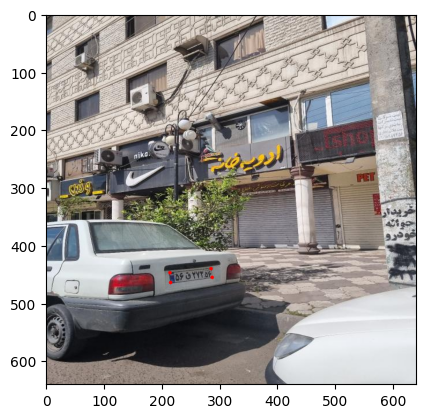

In [ ]:
import cv2
img = cv2.imread('20240425_093256_JPG.rf.e149fb2c20bec16d4b8dea5ec0245cf3.jpg')
img = cv2.resize(img, (640,640))
keyps = result.keypoints.xy.cpu().numpy().astype('int32')[0]
cv2.circle(img, (keyps[0,0],keyps[0,1]), 3, (0,0,255), -1)
cv2.circle(img, (keyps[1,0],keyps[1,1]), 3, (0,0,255), -1)
cv2.circle(img, (keyps[2,0],keyps[2,1]), 3, (0,0,255), -1)
cv2.circle(img, (keyps[3,0],keyps[3,1]), 3, (0,0,255), -1)

plt.imshow(img[...,::-1])

Seems pretty accurate :)  
DONE! now we have our plate `detection` model, that returns `keypoints` so that we can apply perspective transform and give it to a recognition model.

___